# Predict viral tweets

In [5]:
SEED = 26062019

test_size = 0.5 

import sys
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn import __version__ as sk_vers
import matplotlib.pyplot as plt
from matplotlib import __version__ as m_vers

#import pickle
#from yellowbrick import __version__ as yb_vers
#import NLP_functions as func
#from pattern import __version__ as pat_vers
#import random
#from sklearn import datasets, svm, model_selection, tree, preprocessing, metrics
#import sklearn.ensemble as ske
#import re
#import xgboost as xgb
#import seaborn as sns


print('Current versions Modules:\n')
print('Pandas version:\t\t' + pd.__version__)
print('Matplotlib version:\t' + m_vers)
print('numpy version:\t\t' + np.__version__)
print('sklearn version:\t' + sk_vers)

Current versions Modules:

Pandas version:		0.24.2
Matplotlib version:	3.1.0
numpy version:		1.16.4
sklearn version:	0.21.2


#### install NLTK

In [4]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\levrex\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 1. Load data

In [7]:
df_tweets = pd.read_csv(r'input/trumptweets.csv', sep=',')
df_tweets['date'] = pd.to_datetime(df_tweets['date']) # interpret date as pd.datetime
print('nr of tweets: ', len(df_tweets))
df_tweets.head()

nr of tweets:  41122


,id,link,content,date,retweets,favorites,mentions,hashtags,geo
0,1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 20:54:25,500,868,NaN,NaN,NaN
1,1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-05 03:00:10,33,273,NaN,NaN,NaN
2,1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 15:38:08,12,18,NaN,NaN,NaN
3,1741160716,https://twitter.com/realDonaldTrump/status/174...,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 22:40:15,11,24,NaN,NaN,NaN
4,1773561338,https://twitter.com/realDonaldTrump/status/177...,"""My persona will never be that of a wallflower...",2009-05-12 16:07:28,1399,1965,NaN,NaN,NaN


In [8]:
print('First tweet: ', df_tweets['date'].min())
print('Final tweet: ', df_tweets['date'].max())

First tweet:  2009-05-04 20:54:25
Final tweet:  2020-01-20 02:57:49


### Date cut-off
Only select tweets after the moment he announced that he was a presidential candidate

In [9]:
df_tweets.loc[32059]['content']

'# FraudNewsCNN # FNNpic.twitter.com/WYUnHjjUjg'

In [10]:
df_tweets = df_tweets[df_tweets['date']>pd.Timestamp('2015-06-16T12')] 
print(len(df_tweets))

17823


### Simple Cleaning

In [11]:
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

def lemmatizingText(sentence):
    """
    This function normalizes words with the pattern.nl package. 
    Lemmatisation returns words to the base form. The base form
    should be a valid word in the language.
    Example: Walking, Walks and Walked are all translated to 
        Walk
        
    Input: 
        sentence = written text from an EHR record or another
            Natural Language type record (str)
    """
    lemmatizer = WordNetLemmatizer() 
    return ' '.join([lemmatizer.lemmatize(x) for x in sentence.split(' ')])

def simpleCleaning(sentence):
    # at this moment we ignore whether or not a term is tagged
    sticky_chars = r'([!,.:"#;@\-\+\\/&=\]\[<>^\*`â€™\(\)\d])'
    sentence = re.sub(sticky_chars, r' ', sentence)
    sentence = sentence.lower()
    return sentence

def removeStopWords(sentence):
    return ' '.join([i for i in tweet_tokenizer.tokenize(sentence) if i not in stopwords.words('english')])

tweet_tokenizer = TweetTokenizer()

# convert to lowercase
df_tweets['content'] = df_tweets['content'].str.lower()
# remove links (pic is used for pictures)
df_tweets['content'] = df_tweets['content'].str.replace('http\S+|www.\S+|pic.\S+', '', case=False) #tweet_tokens
# simple cleaning
df_tweets['content'] = df_tweets['content'].apply(lambda x : simpleCleaning(x))       
# lemmatizing
df_tweets['content'] = df_tweets['content'].apply(lambda x : lemmatizingText(x))     
# remove stop words
df_tweets['content'] = df_tweets['content'].apply(lambda x : removeStopWords(x))
# remove spaces
df_tweets['content'] = df_tweets['content'].str.replace(' +', ' ', case=False)

## Most popular tweet

In [10]:
df_tweets[df_tweets['favorites']==df_tweets['favorites'].max()]

,id,link,content,date,retweets,favorites,mentions,hashtags,geo
38625,1157345692517634049,https://twitter.com/realDonaldTrump/status/115...,$ ap rocky released prison way home united sta...,2019-08-02 19:41:30,240363,857678,NaN,NaN,NaN


In [11]:
df_tweets[df_tweets['retweets']==df_tweets['retweets'].max()]

,id,link,content,date,retweets,favorites,mentions,hashtags,geo
32059,881503147168071680,https://twitter.com/realDonaldTrump/status/881...,fraudnewscnn fnn,2017-07-02 15:21:42,309892,528265,NaN,# #,NaN


## 2. Create Train, Validation & Test set

In [13]:
from sklearn.model_selection import train_test_split
SEED = 232020

X = df_tweets['content']
y = df_tweets['retweets']

# test split
# validation splits
#ss = ShuffleSplit(n_splits=10, test_size=0.5, random_state=SEED)
#l_folds = ss.split(X_s)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

print('Size train:\t', len(X_train))
print('Size test:\t', len(X_test))

Size train:	 13367
Size test:	 4456


## 3. Visualize Exploration data
### 3.1 Lexical plot of trainingsset

In [147]:
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.text import DispersionPlot

def plotLexicalDispersion(X, nr_features, title, **kwargs):
    """
    Draws a lexical dispersion plot which visualizes 
    the homogeneity across the corpus. 
    
    Also confirms wheter or not the data is randomized, 
    and visualizes the prevalence of features.
    
    Input:
        X = array with text data (EHR entries)
        nr_features = top n number of features to plot
        n_grams = chunksize for text processing :
            Note: chunksize refers to nr of words / not nr of 
                characters!
        kwargs = arguments for feature vectorizer (TfidfVectorizer):
            ngram_range = specifies the range of the ngram features
    """
    count = 0
    d = {}
    words = []
    for x in X:
        if kwargs['ngram_range'][1] != 1:
            # functie crasht bij hashtags
            l = [i for i in x.split(' ')]
            words.append([' '.join(l[i: i+(kwargs['ngram_range'][1])]) for i in range(len(l)+1) if len(l[i: i+(kwargs['ngram_range'][0])]) <= (kwargs['ngram_range'][1])])
            
            #print(words)
            if len(words[-1]) == 0:
                del words[-1]
        else :
            words.append([i for i in x.split(' ')])
        count+=1
    d = np.array(words)
    count_vect = TfidfVectorizer(ngram_range=kwargs['ngram_range'])
    
    
    X_train_tfidf = count_vect.fit_transform(X) 
    X_pd = pd.DataFrame(X_train_tfidf.toarray(), columns=count_vect.get_feature_names())
    feature_to_plot =list(X_pd.sum().sort_values(ascending=False).keys()[:nr_features]) 
    visualizer = DispersionPlot(feature_to_plot, size=(450, 450))
    ax = visualizer.ax
    ax.tick_params(labelsize=18)
    visualizer.fit(d)
    visualizer.poof()
    return

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


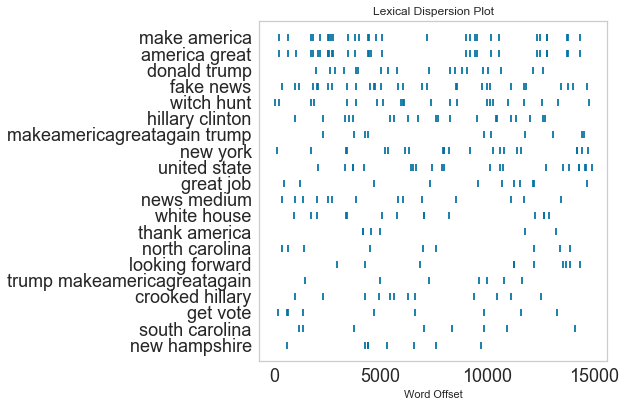

<Figure size 576x396 with 0 Axes>

In [148]:
title ='Lexical Dispersion Plot of most popular chunks (n=2) in last 1000 Trump tweets'
plotLexicalDispersion(X_train.tail(1000), nr_features=20, title=title, ngram_range=(2,2))
plt.savefig('figures/prep/LexicalDispersionPlot.png', bbox_inches='tight')

## 3. Annotate tweets to be either Viral or not Viral (binary labelling)

In [19]:
print('Tweets that qualify as being popular (10% of total in exploration set): ', round(len(y_train)*0.1))

Tweets that qualify as being popular (10% of total in exploration set):  1337


In [87]:
class_y_train = y_train.sort_values().reset_index()
minimal_ix = len(y_train) - round(len(y_train)*0.1)
cutoff = class_y_train.loc[minimal_ix]['retweets']
print('Tweets with more than %s retweets are considered to be viral in Trump terms!' % (cutoff))

# Relabel y_Train & y_test to binary label (Viral or not Viral)
y_train_proc = y_train.sort_values().apply(lambda x: 'True' if x > cutoff else 'False')
y_test_proc = y_test.sort_values().apply(lambda x: 'True' if x > cutoff else 'False')

Tweets with more than 25084 retweets are considered to be viral in Trump terms!


### 3.1 Distribution Favorites with cut-off

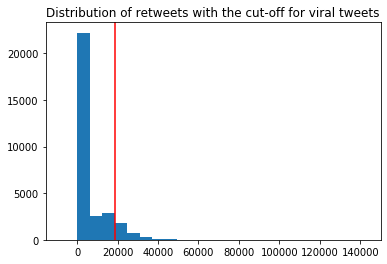

In [15]:
plt.hist(y_train.sort_values(), bins=50)
plt.axvline(x=cutoff, color='r')
plt.xlim(right=150000) 
plt.title('Distribution of retweets with the cut-off for viral tweets')
plt.savefig('figures/prep/DistributionFavoriteTweets.png', bbox_inches='tight')

### 3.2 Distribution classes (Viral / Non Viral)

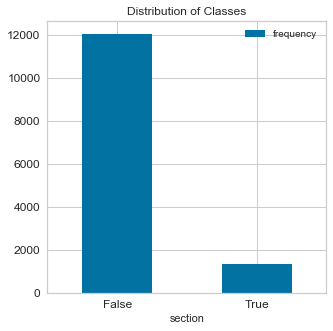

In [19]:
from collections import Counter

labels, values = zip(*Counter(y_train_proc).items())
df = pd.DataFrame({'section':labels, 'frequency':values})
ax = df.plot(kind='bar',  title ="Distribution of Classes", figsize=(5, 5), x='section', legend=True, fontsize=12, rot=0)

## 4. Investigating Vector space (Word2Vec)

In [84]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\levrex\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

### 4.1 creating Vectorspace with Word2Vec

In [178]:
from sklearn.naive_bayes import MultinomialNB
import gensim 
from gensim.models import Word2Vec
tweet_tokens = []

# later on respect the l_folds

for sent in X_train:
    tweet_tokens.append(tweet_tokenizer.tokenize(sent))

print('Training word2vec model...')
word2vec = Word2Vec(tweet_tokens, size=100, window=5, min_count=5, workers=4)  
word2vec.init_sims(replace=True)


Size train:	 13367
Size test:	 4456
Training word2vec model...


### 4.2 Investigating the vector space

In [234]:
print("Cosine similarity:\n'america' and 'great':\t", word2vec.wv.similarity('america', 'great')) 
print("'american' and 'great':\t", word2vec.wv.similarity('american', 'great')) 
print("'cnn' and 'fake':\t", word2vec.wv.similarity('cnn', 'fake'))
print("'democrat' and 'great':\t", word2vec.wv.similarity('democrat', 'great')) 
print("'Hillary' and 'great':\t", word2vec.wv.similarity('hillary', 'great')) 
print("'Hillary' and 'crooked':", word2vec.wv.similarity('hillary', 'crooked')) 

Cosine similarity:
'america' and 'great':	 0.96070176
'american' and 'great':	 0.7700361
'cnn' and 'fake':	 0.8299973
'democrat' and 'great':	 0.16770846
'Hillary' and 'great':	 -0.0682913
'Hillary' and 'crooked': 0.9585856


In [239]:
print("News + Trump - FoxNews = ", word2vec.wv.most_similar(positive=['news', 'trump'], negative=['foxnews'], topn=1))
print("News + Trump - CNN = ", word2vec.wv.most_similar(positive=['news', 'trump'], negative=['cnn'], topn=1))
print("Which one doesn't match: Trump, Democrat, Republican and Foxnews:", word2vec.wv.doesnt_match("trump democrat republican foxnews".split()))

News + Trump - FoxNews =  [('cnn', 0.8376795053482056)]
News + Trump - CNN =  [('foxnews', 0.851902961730957)]
Which one doesn't match: Trump, Democrat, Republican and Foxnews: democrat


In [247]:
print("Most associations with Hillary")
word2vec.wv.similar_by_word("hillary", 5)

Most associations with Hillary


[('clinton', 0.9729011058807373),
 ('crooked', 0.9585856199264526),
 ('flunky', 0.8961525559425354),
 ('campaign', 0.8677566647529602),
 ('foundation', 0.8625138998031616)]

## 5. Build Classifier 
1. Use TFIDF vectorizer (Word2Vec cannot be used for a classifier?)
2. Use ROC curve with 5 cross folds 

In [108]:
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

def plotSTD(tprs, aucs, color, lbl, linestyle='-', lw=5):
        """
        Plot the standard deviation of the ROC-curves

        Input:
            tprs = list of true positive rates per iteration
            aucs = list of area under the curve per iteration
            lbl = name of the classifier (string)
            color = specify color of the classifier
            lw = linewidth (float)
        Output:
            plt = matplotlib pyplot featuring the standard 
                deviation of the ROC curve from the classifier
            std_auc = standard deviation of the auc (float)
        """
        mean_fpr = np.linspace(0, 1, 100)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr [-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        print(lbl + ' ' + str(mean_auc) +' (std : +/-' + "%.2f" % std_auc + ' )')
        plt.plot(mean_fpr, mean_tpr, color=color,
            label=lbl + r' mean kfold (AUC = %.2f +/- %.2f)' % (mean_auc, std_auc),
            alpha=.5, linestyle=linestyle, linewidth=lw)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=color, alpha=.1)
        return plt 

accuracy 0.7614061331338818
              precision    recall  f1-score   support

           0       0.90      0.83      0.86      2419
           1       0.08      0.15      0.11       255

    accuracy                           0.76      2674
   macro avg       0.49      0.49      0.48      2674
weighted avg       0.82      0.76      0.79      2674

accuracy 0.7602842183994016
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      2397
           1       0.09      0.15      0.11       277

    accuracy                           0.76      2674
   macro avg       0.49      0.49      0.49      2674
weighted avg       0.81      0.76      0.78      2674

accuracy 0.7744951383694839
              precision    recall  f1-score   support

           0       0.90      0.85      0.87      2408
           1       0.08      0.12      0.10       266

    accuracy                           0.77      2674
   macro avg       0.49      0.49      0.48 

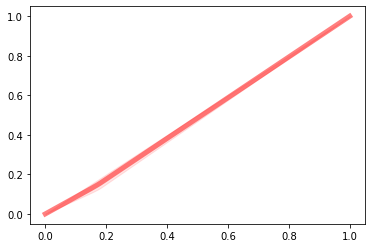

In [109]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.model_selection import ShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
import gensim 
from gensim.models import Word2Vec

sgd = Pipeline([('tfidf', TfidfVectorizer()),
                ('clf', PassiveAggressiveClassifier(class_weight = {1 : 10})), # probability=True
               ])

# later on respect the l_folds
ss = ShuffleSplit(n_splits=5, test_size=0.2, random_state=SEED)
l_folds = [(train, test) for train, test in ss.split(X_train)]

tprs, aucs = [], []
fpr_scale = np.linspace(0, 1, 100)

for train_ix, test_ix in l_folds:
    clf = sgd.fit(X_train.iloc[train_ix], np.array([1 if i == 'True' else 0 for i in y_train_proc.iloc[train_ix]]))
    y_pred = sgd.predict(X_train.iloc[test_ix])
    # Calculating the score of the predictions
    y_true = np.array([1 if i == 'True' else 0 for i in y_train_proc.iloc[test_ix]])
    #y_pred2 = np.array([1 if i == 'True' else 0 for i in y_pred])
    #print(list(y_pred))
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    tprs.append(np.interp(fpr_scale, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    
    print('accuracy %s' % accuracy_score(y_pred, y_true))
    print(classification_report(y_true, y_pred))
plt = plotSTD(tprs, aucs, 'r', 'SGD')